# Calculating Wavelet Transform Plot as features

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import mne
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
os.chdir("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/CleanSep/")
dataset = pd.read_csv("cleaned_data_asr_fix_v1.csv")
dataset

,0,1,2,3,4,5,6,7,8,9,...,997,998,999,Event,handPos,Hand,Action,Subject,Channel,Trial
0,-6.92,-7.04,-7.18,-7.35,-7.52,-7.69,-7.85,-7.98,-8.07,-8.12,...,-9.20,-9.17,-9.16,Fix,palmDown,Right,Open,P01,1,0
1,-7.83,-7.64,-7.46,-7.27,-7.09,-6.90,-6.71,-6.52,-6.32,-6.12,...,-0.10,-0.29,-0.48,Fix,palmDown,Right,Open,P01,2,0
2,-7.87,-7.54,-7.17,-6.76,-6.32,-5.87,-5.41,-4.96,-4.53,-4.13,...,-2.77,-2.62,-2.52,Fix,palmDown,Right,Open,P01,3,0
3,-1.14,-0.93,-0.75,-0.61,-0.51,-0.45,-0.43,-0.44,-0.48,-0.56,...,-4.28,-3.89,-3.55,Fix,palmDown,Right,Open,P01,4,0
4,-8.30,-8.16,-7.96,-7.71,-7.40,-7.05,-6.65,-6.23,-5.78,-5.31,...,8.10,7.97,7.78,Fix,palmDown,Right,Open,P01,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769915,8.82,8.21,7.50,6.72,5.91,5.08,4.27,3.50,2.80,2.19,...,-10.10,-10.29,-10.18,Action,palmUp,Right,Close,FP12,58,959
769916,12.37,11.62,10.73,9.72,8.63,7.49,6.32,5.17,4.05,3.01,...,-18.79,-18.98,-18.81,Action,palmUp,Right,Close,FP12,59,959
769917,6.91,6.91,6.89,6.86,6.82,6.75,6.65,6.51,6.31,6.05,...,-8.47,-7.65,-6.60,Action,palmUp,Right,Close,FP12,60,959
769918,4.53,4.61,4.67,4.71,4.75,4.78,4.82,4.87,4.93,5.00,...,-5.12,-5.36,-5.53,Action,palmUp,Right,Close,FP12,61,959


# Code using daubechies 6 wavelet

In [5]:
import numpy as np
import pywt
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

In [6]:
# Find list of channels available for every participant
chans, chan_count = np.unique(dataset["Channel"], return_counts=True)
good_chans = [i+1 for i in range(len(chan_count)) if chan_count[i] == 12480]
print(len(good_chans))
print(good_chans)

48
[2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 40, 42, 43, 44, 45, 46, 47, 48, 50, 53, 54, 55, 56, 57, 58, 59, 60, 61]


In [7]:
good_chans_name = [f'E{x}' for x in good_chans]
print(good_chans_name)

['E2', 'E3', 'E4', 'E5', 'E6', 'E8', 'E9', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E22', 'E23', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30', 'E31', 'E32', 'E33', 'E34', 'E36', 'E38', 'E40', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E50', 'E53', 'E54', 'E55', 'E56', 'E57', 'E58', 'E59', 'E60', 'E61']


In [8]:
ch_type = "eeg"
nchan = 64
sf = 1000
channels = [f'E{n:1}' for n in range(1, nchan+1)]
mne.channels.get_builtin_montages()
chans = mne.channels.make_standard_montage('GSN-HydroCel-64_1.0')
info = mne.create_info(channels, sfreq=sf, ch_types=ch_type)
info.set_montage(chans)

<Info | 8 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 1000.0 Hz
>

In [9]:
# Import preprocessed file
data_path = "/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/PreprocessedData/Preprocess ASR"
exclusion = ["FP01.set", "FP10.set"]

In [10]:
def get_action_events(events):
    new_keys_dict = {}
    for key in events[1].keys():
        if "ActionBeg" in key:
            new_keys_dict[key] = events[1][key]
    
    new_event_times = [row for row in events[0] if row[2] in new_keys_dict.values()] 
    return (new_event_times, new_keys_dict)

In [36]:
os.chdir(data_path)
freqs = np.arange(1, 46)

# eeg_wt, annotation = [], []
X, labels = [], []
for files in glob.glob("*.set"):
    if files not in exclusion:
        # Read EEG and event file
        arr = mne.io.read_raw_eeglab(files, verbose=0)
        events = mne.events_from_annotations(arr, verbose=0)
        # Extracting events of interest
        new_events = get_action_events(events)

        # Working with epochs
        epochs = mne.Epochs(arr, new_events[0], event_id=new_events[1], picks=good_chans_name,
                            tmin=-0.1, tmax=0.999,  baseline=None, verbose=False)
        for idx in range(len(epochs.events)):
            epoch_eeg = epoch_df[epoch_df["epoch"] == idx].iloc[:, 3:].T
            
            X.append(epoch_eeg)
            labels.append(epoch_df[epoch_df["epoch"] == idx].iloc[0, 1])
            
            print(len(X), len(labels))
            
X = np.array(X)
labels = np.array(labels)
X.shape, labels.shape

1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
61 61
62 62
63 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78
79 79
80 80
81 81
82 82
83 83
84 84
85 85
86 86
87 87
88 88
89 89
90 90
91 91
92 92
93 93
94 94
95 95
96 96
97 97
98 98
99 99
100 100
101 101
102 102
103 103
104 104
105 105
106 106
107 107
108 108
109 109
110 110
111 111
112 112
113 113
114 114
115 115
116 116
117 117
118 118
119 119
120 120
121 121
122 122
123 123
124 124
125 125
126 126
127 127
128 128
129 129
130 130
131 131
132 132
133 133
134 134
135 135
136 136
137 137
138 138
139 139
140 140
141 141
142 142
143 143
144 144
145 145
146 146
147 147
148 148
149 149
150 150
151 151
152 152


1085 1085
1086 1086
1087 1087
1088 1088
1089 1089
1090 1090
1091 1091
1092 1092
1093 1093
1094 1094
1095 1095
1096 1096
1097 1097
1098 1098
1099 1099
1100 1100
1101 1101
1102 1102
1103 1103
1104 1104
1105 1105
1106 1106
1107 1107
1108 1108
1109 1109
1110 1110
1111 1111
1112 1112
1113 1113
1114 1114
1115 1115
1116 1116
1117 1117
1118 1118
1119 1119
1120 1120
1121 1121
1122 1122
1123 1123
1124 1124
1125 1125
1126 1126
1127 1127
1128 1128
1129 1129
1130 1130
1131 1131
1132 1132
1133 1133
1134 1134
1135 1135
1136 1136
1137 1137
1138 1138
1139 1139
1140 1140
1141 1141
1142 1142
1143 1143
1144 1144
1145 1145
1146 1146
1147 1147
1148 1148
1149 1149
1150 1150
1151 1151
1152 1152
1153 1153
1154 1154
1155 1155
1156 1156
1157 1157
1158 1158
1159 1159
1160 1160
1161 1161
1162 1162
1163 1163
1164 1164
1165 1165
1166 1166
1167 1167
1168 1168
1169 1169
1170 1170
1171 1171
1172 1172
1173 1173
1174 1174
1175 1175
1176 1176
1177 1177
1178 1178
1179 1179
1180 1180
1181 1181
1182 1182
1183 1183
1184 1184


1921 1921
1922 1922
1923 1923
1924 1924
1925 1925
1926 1926
1927 1927
1928 1928
1929 1929
1930 1930
1931 1931
1932 1932
1933 1933
1934 1934
1935 1935
1936 1936
1937 1937
1938 1938
1939 1939
1940 1940
1941 1941
1942 1942
1943 1943
1944 1944
1945 1945
1946 1946
1947 1947
1948 1948
1949 1949
1950 1950
1951 1951
1952 1952
1953 1953
1954 1954
1955 1955
1956 1956
1957 1957
1958 1958
1959 1959
1960 1960
1961 1961
1962 1962
1963 1963
1964 1964
1965 1965
1966 1966
1967 1967
1968 1968
1969 1969
1970 1970
1971 1971
1972 1972
1973 1973
1974 1974
1975 1975
1976 1976
1977 1977
1978 1978
1979 1979
1980 1980
1981 1981
1982 1982
1983 1983
1984 1984
1985 1985
1986 1986
1987 1987
1988 1988
1989 1989
1990 1990
1991 1991
1992 1992
1993 1993
1994 1994
1995 1995
1996 1996
1997 1997
1998 1998
1999 1999
2000 2000
2001 2001
2002 2002
2003 2003
2004 2004
2005 2005
2006 2006
2007 2007
2008 2008
2009 2009
2010 2010
2011 2011
2012 2012
2013 2013
2014 2014
2015 2015
2016 2016
2017 2017
2018 2018
2019 2019
2020 2020


2776 2776
2777 2777
2778 2778
2779 2779
2780 2780
2781 2781
2782 2782
2783 2783
2784 2784
2785 2785
2786 2786
2787 2787
2788 2788
2789 2789
2790 2790
2791 2791
2792 2792
2793 2793
2794 2794
2795 2795
2796 2796
2797 2797
2798 2798
2799 2799
2800 2800
2801 2801
2802 2802
2803 2803
2804 2804
2805 2805
2806 2806
2807 2807
2808 2808
2809 2809
2810 2810
2811 2811
2812 2812
2813 2813
2814 2814
2815 2815
2816 2816
2817 2817
2818 2818
2819 2819
2820 2820
2821 2821
2822 2822
2823 2823
2824 2824
2825 2825
2826 2826
2827 2827
2828 2828
2829 2829
2830 2830
2831 2831
2832 2832
2833 2833
2834 2834
2835 2835
2836 2836
2837 2837
2838 2838
2839 2839
2840 2840
2841 2841
2842 2842
2843 2843
2844 2844
2845 2845
2846 2846
2847 2847
2848 2848
2849 2849
2850 2850
2851 2851
2852 2852
2853 2853
2854 2854
2855 2855
2856 2856
2857 2857
2858 2858
2859 2859
2860 2860
2861 2861
2862 2862
2863 2863
2864 2864
2865 2865
2866 2866
2867 2867
2868 2868
2869 2869
2870 2870
2871 2871
2872 2872
2873 2873
2874 2874
2875 2875


3611 3611
3612 3612
3613 3613
3614 3614
3615 3615
3616 3616
3617 3617
3618 3618
3619 3619
3620 3620
3621 3621
3622 3622
3623 3623
3624 3624
3625 3625
3626 3626
3627 3627
3628 3628
3629 3629
3630 3630
3631 3631
3632 3632
3633 3633
3634 3634
3635 3635
3636 3636
3637 3637
3638 3638
3639 3639
3640 3640
3641 3641
3642 3642
3643 3643
3644 3644
3645 3645
3646 3646
3647 3647
3648 3648
3649 3649
3650 3650
3651 3651
3652 3652
3653 3653
3654 3654
3655 3655
3656 3656
3657 3657
3658 3658
3659 3659
3660 3660
3661 3661
3662 3662
3663 3663
3664 3664
3665 3665
3666 3666
3667 3667
3668 3668
3669 3669
3670 3670
3671 3671
3672 3672
3673 3673
3674 3674
3675 3675
3676 3676
3677 3677
3678 3678
3679 3679
3680 3680
3681 3681
3682 3682
3683 3683
3684 3684
3685 3685
3686 3686
3687 3687
3688 3688
3689 3689
3690 3690
3691 3691
3692 3692
3693 3693
3694 3694
3695 3695
3696 3696
3697 3697
3698 3698
3699 3699
3700 3700
3701 3701
3702 3702
3703 3703
3704 3704
3705 3705
3706 3706
3707 3707
3708 3708
3709 3709
3710 3710


4448 4448
4449 4449
4450 4450
4451 4451
4452 4452
4453 4453
4454 4454
4455 4455
4456 4456
4457 4457
4458 4458
4459 4459
4460 4460
4461 4461
4462 4462
4463 4463
4464 4464
4465 4465
4466 4466
4467 4467
4468 4468
4469 4469
4470 4470
4471 4471
4472 4472
4473 4473
4474 4474
4475 4475
4476 4476
4477 4477
4478 4478
4479 4479
4480 4480
4481 4481
4482 4482
4483 4483
4484 4484
4485 4485
4486 4486
4487 4487
4488 4488
4489 4489
4490 4490
4491 4491
4492 4492
4493 4493
4494 4494
4495 4495
4496 4496
4497 4497
4498 4498
4499 4499
4500 4500
4501 4501
4502 4502
4503 4503
4504 4504
4505 4505
4506 4506
4507 4507
4508 4508
4509 4509
4510 4510
4511 4511
4512 4512
4513 4513
4514 4514
4515 4515
4516 4516
4517 4517
4518 4518
4519 4519
4520 4520
4521 4521
4522 4522
4523 4523
4524 4524
4525 4525
4526 4526
4527 4527
4528 4528
4529 4529
4530 4530
4531 4531
4532 4532
4533 4533
4534 4534
4535 4535
4536 4536
4537 4537
4538 4538
4539 4539
4540 4540
4541 4541
4542 4542
4543 4543
4544 4544
4545 4545
4546 4546
4547 4547


5281 5281
5282 5282
5283 5283
5284 5284
5285 5285
5286 5286
5287 5287
5288 5288
5289 5289
5290 5290
5291 5291
5292 5292
5293 5293
5294 5294
5295 5295
5296 5296
5297 5297
5298 5298
5299 5299
5300 5300
5301 5301
5302 5302
5303 5303
5304 5304
5305 5305
5306 5306
5307 5307
5308 5308
5309 5309
5310 5310
5311 5311
5312 5312
5313 5313
5314 5314
5315 5315
5316 5316
5317 5317
5318 5318
5319 5319
5320 5320
5321 5321
5322 5322
5323 5323
5324 5324
5325 5325
5326 5326
5327 5327
5328 5328
5329 5329
5330 5330
5331 5331
5332 5332
5333 5333
5334 5334
5335 5335
5336 5336
5337 5337
5338 5338
5339 5339
5340 5340
5341 5341
5342 5342
5343 5343
5344 5344
5345 5345
5346 5346
5347 5347
5348 5348
5349 5349
5350 5350
5351 5351
5352 5352
5353 5353
5354 5354
5355 5355
5356 5356
5357 5357
5358 5358
5359 5359
5360 5360
5361 5361
5362 5362
5363 5363
5364 5364
5365 5365
5366 5366
5367 5367
5368 5368
5369 5369
5370 5370
5371 5371
5372 5372
5373 5373
5374 5374
5375 5375
5376 5376
5377 5377
5378 5378
5379 5379
5380 5380


6143 6143
6144 6144
6145 6145
6146 6146
6147 6147
6148 6148
6149 6149
6150 6150
6151 6151
6152 6152
6153 6153
6154 6154
6155 6155
6156 6156
6157 6157
6158 6158
6159 6159
6160 6160
6161 6161
6162 6162
6163 6163
6164 6164
6165 6165
6166 6166
6167 6167
6168 6168
6169 6169
6170 6170
6171 6171
6172 6172
6173 6173
6174 6174
6175 6175
6176 6176
6177 6177
6178 6178
6179 6179
6180 6180
6181 6181
6182 6182
6183 6183
6184 6184
6185 6185
6186 6186
6187 6187
6188 6188
6189 6189
6190 6190
6191 6191
6192 6192
6193 6193
6194 6194
6195 6195
6196 6196
6197 6197
6198 6198
6199 6199
6200 6200
6201 6201
6202 6202
6203 6203
6204 6204
6205 6205
6206 6206
6207 6207
6208 6208
6209 6209
6210 6210
6211 6211
6212 6212
6213 6213
6214 6214
6215 6215
6216 6216
6217 6217
6218 6218
6219 6219
6220 6220
6221 6221
6222 6222
6223 6223
6224 6224
6225 6225
6226 6226
6227 6227
6228 6228
6229 6229
6230 6230
6231 6231
6232 6232
6233 6233
6234 6234
6235 6235
6236 6236
6237 6237
6238 6238
6239 6239
6240 6240


((6240, 48, 1000), (6240,))

In [41]:
# Load EEG data
eeg_data = X  # shape: (num_samples, num_channels, num_samples_per_channel)
labels = np.array([y.split("-")[-1] for y in labels])  # shape: (num_samples,)

# Define wavelet parameters
wavelet = pywt.Wavelet('db6')
level = 5

In [45]:
# Apply wavelet transform to EEG data to extract time-frequency information
num_samples = eeg_data.shape[0]
num_channels = eeg_data.shape[1]
num_samples_per_channel = eeg_data.shape[2]
tf_data = np.zeros((num_samples, num_channels, num_samples_per_channel, level))

for i in range(num_samples):
    for j in range(num_channels):
        coeffs = pywt.wavedec(eeg_data[i, j, :], wavelet, level=level)
        print(len(coeffs))
        tf_data[i, j, :, :] = coeffs

# Reshape the data for LSTM input
tf_data = tf_data.reshape(num_samples, num_channels, -1)
tf_data.shape

6


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

In [ ]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(tf_data, labels, test_size=0.2, random_state=42)

# Define LSTM model
model = Sequential()
model.add(LSTM(units=128, input_shape=(num_channels, tf_data.shape[2])))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

In [ ]:
temp = dataset[(dataset["Subject"] == "P02") & (dataset["Trial"] == 0)]
temp.iloc[:, :-7]

In [ ]:
# Find list of channels available for every participant
chans, chan_count = np.unique(dataset["Channel"], return_counts=True)
good_chans = [i+1 for i in range(len(chan_count)) if chan_count[i] == 12480]
print(len(good_chans))
print(good_chans)

In [ ]:
good_chans_name = [f'E{x}' for x in good_chans]
print(good_chans_name)

In [ ]:
# Subject-wise channel availability
sub_good_chans = {}
for sub in np.unique(dataset["Subject"]):
    sub_good_chans[sub] = np.unique(dataset[dataset["Subject"] == sub]["Channel"]) 
    sub_good_chans[sub] = [f'E{x}' for x in sub_good_chans[sub]]
print(sub_good_chans)

In [ ]:
ch_type = "eeg"
nchan = 64
sf = 1000
channels = [f'E{n:1}' for n in range(1, nchan+1)]
mne.channels.get_builtin_montages()
chans = mne.channels.make_standard_montage('GSN-HydroCel-64_1.0')
info = mne.create_info(channels, sfreq=sf, ch_types=ch_type)
info.set_montage(chans)

In [ ]:
# Import preprocessed file
data_path = "/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/PreprocessedData/Preprocess ASR"
exclusion = ["FP01.set", "FP10.set"]

In [ ]:
def get_action_events(events):
    new_keys_dict = {}
    for key in events[1].keys():
        if "ActionBeg" in key:
            new_keys_dict[key] = events[1][key]
        if "FixBeg" in key and "Free" not in key:
            new_keys_dict[key] = events[1][key]
    
    new_event_times = [row for row in events[0] if row[2] in new_keys_dict.values()] 
    return (new_event_times, new_keys_dict)

In [10]:
os.chdir(data_path)
freqs = np.arange(1, 46)

eeg_wt, annotation = [], []
for files in glob.glob("*.set"):
    if files not in exclusion:
        print("#############")
        print(files)
        # Read EEG and event file
        arr = mne.io.read_raw_eeglab(files, verbose=0)
        events = mne.events_from_annotations(arr, verbose=0)
        # Extracting events of interest
        new_events = get_action_events(events)

        # Working with epochs
        epochs = mne.Epochs(arr, new_events[0], event_id=new_events[1], picks=good_chans_name,
                            tmin=0, tmax=0.999,  baseline=None, verbose=False)
        power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_jobs=20, zero_mean=False,
                                           n_cycles=freqs/2, return_itc=False, average=False)
        
        power.save(f'/DATAHDD/shivam/Thesis/Data/CleanSep/morlet_tfr_v2/{files[:-4]}-morlet-tfr.h5')
        
#         eeg_wt.append(power)
        annotation.append(epochs.get_annotations_per_epoch())
        print(len(eeg_wt), len(annotation))

#############
P01.set
0 1
#############
P03.set
0 2
#############
FP03.set
0 3
#############
FP05.set
0 4
#############
FP09.set
0 5
#############
FP07.set
0 6
#############
FP11.set
0 7
#############
P02.set
0 8
#############
FP02.set
0 9
#############
FP13.set
0 10
#############
FP08.set
0 11
#############
FP06.set
0 12
#############
FP12.set
0 13


In [37]:
[x for x in annotation]

[[[(0.0, 0.001, 'FixBeg-palmDown-Right-Open'),
   (0.9719999999999942, 0.001, 'FixEnd-palmDown-Right-Open'),
   (0.9739999999999895, 0.001, 'ActionBeg-palmDown-Right-Open')],
  [(0.0, 0.001, 'ActionBeg-palmDown-Right-Open')],
  [(0.0, 0.001, 'ActionEnd-palmDown-Right-Open'),
   (0.0, 0.001, 'FixBeg-palmDown-Left-Open')],
  [(0.0, 0.001, 'FixEnd-palmDown-Left-Open'),
   (0.0, 0.001, 'ActionBeg-palmDown-Left-Open')],
  [(0.0, 0.001, 'ActionEnd-palmDown-Left-Open'),
   (0.0, 0.001, 'FixBeg-palmDown-Right-Close'),
   (0.9890000000000043, 0.001, 'FixEnd-palmDown-Right-Close'),
   (0.9909999999999997, 0.001, 'ActionBeg-palmDown-Right-Close')],
  [(0.0, 0.001, 'ActionBeg-palmDown-Right-Close')],
  [(0.0, 0.001, 'ActionEnd-palmDown-Right-Close'),
   (0.0, 0.001, 'FixBeg-palmDown-Left-Close')],
  [(0.0, 0.001, 'FixEnd-palmDown-Left-Close'),
   (0.0, 0.001, 'ActionBeg-palmDown-Left-Close')],
  [(0.0, 0.001, 'FixBeg-palmDown-Right-Open')],
  [(0.0, 0.001, 'ActionBeg-palmDown-Right-Open')],
  [(0.

In [3]:
os.chdir("/DATAHDD/shivam/Thesis/Data/CleanSep/morlet_tfr/")
tfr_eeg = []
for tfr in os.listdir():
    tfr_data = mne.time_frequency.read_tfrs(tfr)
    for data in tfr_data[0]:
        tfr_eeg.append(np.mean(data, axis=0))
    print(len(tfr_eeg))

Reading FP03-morlet-tfr.h5 ...
Not setting metadata
960
Reading FP11-morlet-tfr.h5 ...
Not setting metadata
1920
Reading P03-morlet-tfr.h5 ...
Not setting metadata
2880
Reading FP05-morlet-tfr.h5 ...
Not setting metadata
3840
Reading FP02-morlet-tfr.h5 ...
Not setting metadata
4800
Reading P01-morlet-tfr.h5 ...
Not setting metadata
5760
Reading FP13-morlet-tfr.h5 ...
Not setting metadata
6720
Reading P02-morlet-tfr.h5 ...
Not setting metadata
7680
Reading FP07-morlet-tfr.h5 ...
Not setting metadata
8640
Reading FP06-morlet-tfr.h5 ...
Not setting metadata
9600
Reading FP12-morlet-tfr.h5 ...
Not setting metadata
10560
Reading FP09-morlet-tfr.h5 ...
Not setting metadata
11520
Reading FP08-morlet-tfr.h5 ...
Not setting metadata
12480


morlet order: FP03, FP11, P03, FP05, FP02, P01, FP13, P02, FP07, FP06, FP12, FP09, FP08

In [ ]:
os.chdir("/DATAHDD/shivam/Thesis/Data/CleanSep/morlet_tfr/")
tfr_eeg = []
tfr_labels = []
for tfr in os.listdir():
    print(tfr)
    tfr_data = mne.time_frequency.read_tfrs(tfr)
    tfr_df = tfr_data[0].to_data_frame()
    for i in range(960):
        tfr_labels.append(tfr_df[tfr_df["epoch"] == i].iloc[0, 3])
tfr = np.array(tfr)
tfr.shape

FP03-morlet-tfr.h5
Reading FP03-morlet-tfr.h5 ...
Not setting metadata
FP11-morlet-tfr.h5
Reading FP11-morlet-tfr.h5 ...
Not setting metadata
P03-morlet-tfr.h5
Reading P03-morlet-tfr.h5 ...
Not setting metadata
FP05-morlet-tfr.h5
Reading FP05-morlet-tfr.h5 ...
Not setting metadata
FP02-morlet-tfr.h5
Reading FP02-morlet-tfr.h5 ...
Not setting metadata
P01-morlet-tfr.h5
Reading P01-morlet-tfr.h5 ...


In [6]:
tfr_eeg = np.array(tfr_eeg)
tfr_eeg.shape

(12480, 45, 1000)

In [7]:
np.save("/DATAHDD/shivam/Thesis/Data/CleanSep/morlet_tfr_averaged.npy", tfr_eeg)


In [13]:
tfr_df = tfr_data[0].to_data_frame()
tfr_df

,time,freq,epoch,condition,E2,E3,E4,E5,E6,E8,...,E50,E53,E54,E55,E56,E57,E58,E59,E60,E61
0,0.00,1.00,0,FixBeg-palmUp-Right-Open,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,0,FixBeg-palmUp-Right-Open,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,1.00,0,FixBeg-palmUp-Right-Open,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,1.00,0,FixBeg-palmUp-Right-Open,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,1.00,0,FixBeg-palmUp-Right-Open,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43199995,0.99,45.00,959,ActionBeg-palmIn-Right-Close,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
43199996,1.00,45.00,959,ActionBeg-palmIn-Right-Close,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
43199997,1.00,45.00,959,ActionBeg-palmIn-Right-Close,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
43199998,1.00,45.00,959,ActionBeg-palmIn-Right-Close,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [26]:
labels = []
for i in range(960):
    labels.append(tfr_df[tfr_df["epoch"] == i].iloc[0, 3])
labels

['FixBeg-palmUp-Right-Open',
 'ActionBeg-palmUp-Right-Open',
 'FixBeg-palmUp-Left-Open',
 'ActionBeg-palmUp-Left-Open',
 'FixBeg-palmUp-Right-Close',
 'ActionBeg-palmUp-Right-Close',
 'FixBeg-palmUp-Left-Close',
 'ActionBeg-palmUp-Left-Close',
 'FixBeg-palmUp-Right-Open',
 'ActionBeg-palmUp-Right-Open',
 'FixBeg-palmUp-Right-Close',
 'ActionBeg-palmUp-Right-Close',
 'FixBeg-palmUp-Left-Open',
 'ActionBeg-palmUp-Left-Open',
 'FixBeg-palmUp-Left-Close',
 'ActionBeg-palmUp-Left-Close',
 'FixBeg-palmUp-Left-Open',
 'ActionBeg-palmUp-Left-Open',
 'FixBeg-palmUp-Left-Close',
 'ActionBeg-palmUp-Left-Close',
 'FixBeg-palmUp-Right-Open',
 'ActionBeg-palmUp-Right-Open',
 'FixBeg-palmUp-Right-Close',
 'ActionBeg-palmUp-Right-Close',
 'FixBeg-palmUp-Left-Open',
 'ActionBeg-palmUp-Left-Open',
 'FixBeg-palmUp-Right-Open',
 'ActionBeg-palmUp-Right-Open',
 'FixBeg-palmUp-Left-Close',
 'ActionBeg-palmUp-Left-Close',
 'FixBeg-palmUp-Right-Close',
 'ActionBeg-palmUp-Right-Close',
 'FixBeg-palmUp-Right-Op

In [24]:
tfr_df[tfr_df["epoch"] == 0].iloc[0, 3]

'FixBeg-palmUp-Right-Open'

In [3]:
# os.chdir("/DATAHDD/shivam/Thesis/Data/CleanSep/morlet_tfr/")
# tfr_data = mne.time_frequency.read_tfrs("FP03-morlet-tfr.h5")
# tfr_data

Reading FP03-morlet-tfr.h5 ...
Not setting metadata


[<EpochsTFR | time : [0.000000, 0.999000], freq : [1.000000, 45.000000], epochs : 960, channels : 48, ~15.45 GB>]

In [4]:
tfr_df = tfr_data[0].to_data_frame()
tfr_df

,time,freq,epoch,condition,E2,E3,E4,E5,E6,E8,...,E50,E53,E54,E55,E56,E57,E58,E59,E60,E61
0,0.00,1.00,0,FixBeg-palmUp-Right-Open,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,0,FixBeg-palmUp-Right-Open,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,1.00,0,FixBeg-palmUp-Right-Open,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,1.00,0,FixBeg-palmUp-Right-Open,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,1.00,0,FixBeg-palmUp-Right-Open,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43199995,0.99,45.00,959,ActionBeg-palmDown-Right-Close,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
43199996,1.00,45.00,959,ActionBeg-palmDown-Right-Close,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
43199997,1.00,45.00,959,ActionBeg-palmDown-Right-Close,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
43199998,1.00,45.00,959,ActionBeg-palmDown-Right-Close,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
tfr_np = tfr_df.to_numpy()
tfr_np

In [2]:
import sys
sys.getsizeof(tfr_data)

NameError: name 'tfr_data' is not defined

In [12]:
type(tfr_df.iloc[10, 10])

numpy.float64

In [33]:
os.chdir("/DATAHDD/shivam/Thesis/Data/CleanSep/morlet_tfr/")
tfr_data = mne.time_frequency.read_tfrs("FP06-morlet-tfr.h5")
tfr_data

Reading FP06-morlet-tfr.h5 ...
Not setting metadata


[<EpochsTFR | time : [0.000000, 0.999000], freq : [1.000000, 45.000000], epochs : 960, channels : 48, ~15.45 GB>]

In [36]:
for data in tfr_data[0]:
    print(data.shape)

(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1000)
(48, 45, 1

In [32]:
tfr_data[0].to_data_frame()

,time,freq,epoch,condition,E2,E3,E4,E5,E6,E8,...,E50,E53,E54,E55,E56,E57,E58,E59,E60,E61
0,0.00,1.00,0,FixBeg-palmUp-Right-Open,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,0,FixBeg-palmUp-Right-Open,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,1.00,0,FixBeg-palmUp-Right-Open,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,1.00,0,FixBeg-palmUp-Right-Open,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,1.00,0,FixBeg-palmUp-Right-Open,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43199995,0.99,45.00,959,ActionBeg-palmDown-Right-Close,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
43199996,1.00,45.00,959,ActionBeg-palmDown-Right-Close,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
43199997,1.00,45.00,959,ActionBeg-palmDown-Right-Close,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
43199998,1.00,45.00,959,ActionBeg-palmDown-Right-Close,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [7]:
def get_action_events(events):
    new_keys_dict = {}
    for key in events[1].keys():
        if "ActionBeg" in key:
            new_keys_dict[key] = events[1][key]
        if "FixBeg" in key and "Free" not in key:
            new_keys_dict[key] = events[1][key]
    
    new_event_times = [row for row in events[0] if row[2] in new_keys_dict.values()] 
    return (new_event_times, new_keys_dict)

In [9]:
os.chdir("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/PreprocessedData/Preprocess ASR")
sub = "FP02.set"
# Load EEG file
raw = mne.io.read_raw_eeglab(sub, verbose=0, preload=True)
# Extracting events
events = mne.events_from_annotations(raw, verbose=False)
# Extracting events of interest
new_events = get_action_events(events)
# Epoching
epochs = mne.Epochs(raw, new_events[0], event_id=new_events[1], tmin=0, tmax=0.999,  baseline=None, verbose=False)

In [10]:
epochs

Number of events,960
Events,ActionBeg-palmDown-Left-Close: 40ActionBeg-palmDown-Left-Open: 40ActionBeg-palmDown-Right-Close: 40ActionBeg-palmDown-Right-Open: 40ActionBeg-palmIn-Left-Close: 40ActionBeg-palmIn-Left-Open: 40ActionBeg-palmIn-Right-Close: 40ActionBeg-palmIn-Right-Open: 40ActionBeg-palmUp-Left-Close: 40ActionBeg-palmUp-Left-Open: 40ActionBeg-palmUp-Right-Close: 40ActionBeg-palmUp-Right-Open: 40FixBeg-palmDown-Left-Close: 40FixBeg-palmDown-Left-Open: 40FixBeg-palmDown-Right-Close: 40FixBeg-palmDown-Right-Open: 40FixBeg-palmIn-Left-Close: 40FixBeg-palmIn-Left-Open: 40FixBeg-palmIn-Right-Close: 40FixBeg-palmIn-Right-Open: 40FixBeg-palmUp-Left-Close: 40FixBeg-palmUp-Left-Open: 40FixBeg-palmUp-Right-Close: 40FixBeg-palmUp-Right-Open: 40
Time range,0.000 – 0.999 sec
Baseline,off


In [11]:
close_epochs_list = [
    "ActionBeg-palmDown-Left-Close", 
    "ActionBeg-palmDown-Right-Close", 
    "ActionBeg-palmIn-Left-Close",
    "ActionBeg-palmIn-Right-Close",
    "ActionBeg-palmUp-Left-Close",
    "ActionBeg-palmUp-Right-Close"
]
open_epochs_list = [
    "ActionBeg-palmDown-Left-Open", 
    "ActionBeg-palmDown-Right-Open", 
    "ActionBeg-palmIn-Left-Open",
    "ActionBeg-palmIn-Right-Open",
    "ActionBeg-palmUp-Left-Open",
    "ActionBeg-palmUp-Right-Open"
]
close_fix_epochs_list = [
    "FixBeg-palmDown-Left-Close", 
    "FixBeg-palmDown-Right-Close", 
    "FixBeg-palmIn-Left-Close",
    "FixBeg-palmIn-Right-Close",
    "FixBeg-palmUp-Left-Close",
    "FixBeg-palmUp-Right-Close"
]
open_fix_epochs_list = [
    "FixBeg-palmDown-Left-Open", 
    "FixBeg-palmDown-Right-Open", 
    "FixBeg-palmIn-Left-Open",
    "FixBeg-palmIn-Right-Open",
    "FixBeg-palmUp-Left-Open",
    "FixBeg-palmUp-Right-Open"
]

In [12]:
close_epochs_fix = epochs[open_epochs_list]
open_epochs_fix = epochs[close_epochs_list]
# del epochs

Using data from preloaded Raw for 240 events and 1000 original time points ...
0 bad epochs dropped
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated


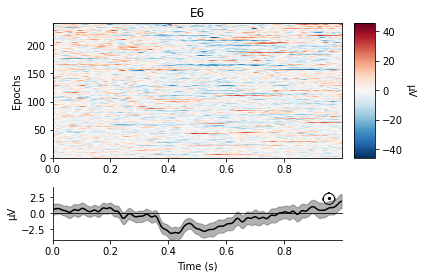

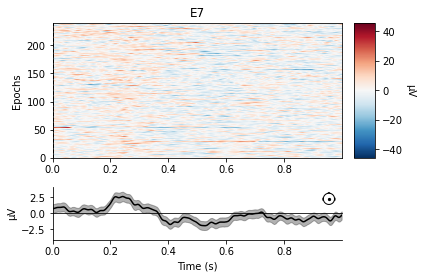

[<Figure size 432x288 with 4 Axes>, <Figure size 432x288 with 4 Axes>]

In [14]:
close_epochs_fix.plot_image(picks=['E6', 'E7'])

Using data from preloaded Raw for 240 events and 1000 original time points ...
0 bad epochs dropped
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated


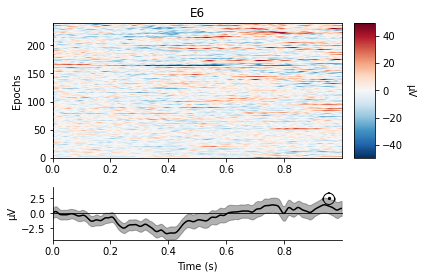

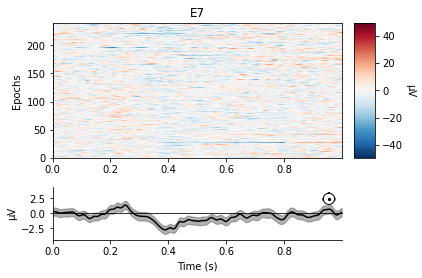

[<Figure size 432x288 with 4 Axes>, <Figure size 432x288 with 4 Axes>]

In [15]:
open_epochs_fix.plot_image(picks=['E6', 'E7'])

In [16]:
freqs = np.arange(1, 46)
open_power = mne.time_frequency.tfr_morlet(open_epochs_fix, freqs=freqs, n_jobs=5, zero_mean=False,
                                           n_cycles=freqs/2, return_itc=False, average=False)
close_power = mne.time_frequency.tfr_morlet(close_epochs_fix, freqs=freqs, n_jobs=5, zero_mean=False,
                                            n_cycles=freqs/2, return_itc=False, average=False)

Using data from preloaded Raw for 240 events and 1000 original time points ...


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  13 tasks      | elapsed:    7.7s
[Parallel(n_jobs=5)]: Done  64 out of  64 | elapsed:   29.4s finished


Not setting metadata
Using data from preloaded Raw for 240 events and 1000 original time points ...


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  13 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done  64 out of  64 | elapsed:   27.6s finished


Not setting metadata


In [17]:
open_power.next().shape

(64, 45, 1000)

ValueError: x and y can be no greater than 2D, but have shapes (64,) and (64, 39, 1000)

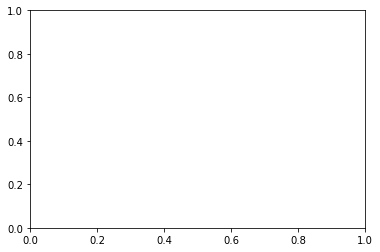

In [56]:
plt.plot(open_power.next())
plt.show()

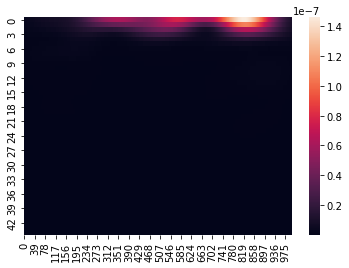

In [18]:
ax = sns.heatmap(np.mean(open_power.next(), axis=0))
plt.show()

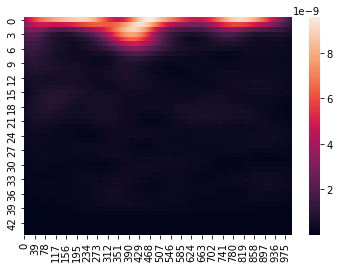

In [19]:
ax = sns.heatmap(np.mean(close_power.next(), axis=0))
plt.show()

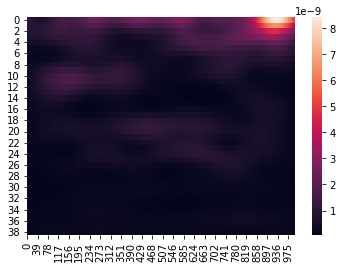

In [69]:
ax = sns.heatmap(np.mean(open_power.next(), axis=0))
plt.show()

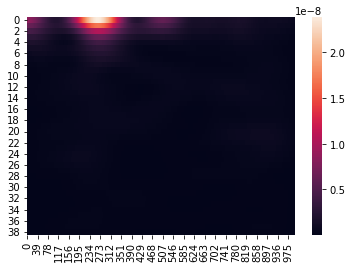

In [68]:
ax = sns.heatmap(np.mean(close_power.next(), axis=0))
plt.show()

In [67]:
np.mean(close_power.next(), axis=0).shape

(39, 1000)

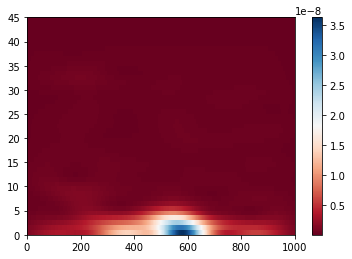

In [20]:
fig, ax = plt.subplots()
c = ax.pcolormesh(np.mean(close_power.next(), axis=0), cmap='RdBu')
fig.colorbar(c, ax=ax)
plt.show()

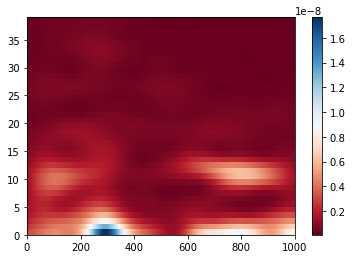

In [77]:
fig, ax = plt.subplots()
c = ax.pcolormesh(np.mean(close_power.next(), axis=0), cmap='RdBu')
fig.colorbar(c, ax=ax)
plt.show()

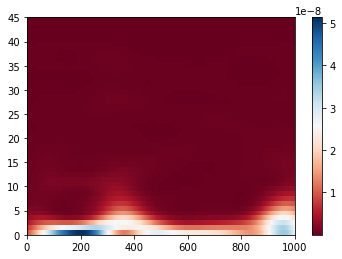

In [21]:
fig, ax = plt.subplots()
c = ax.pcolormesh(np.mean(open_power.next(), axis=0), cmap='RdBu')
fig.colorbar(c, ax=ax)
plt.show()

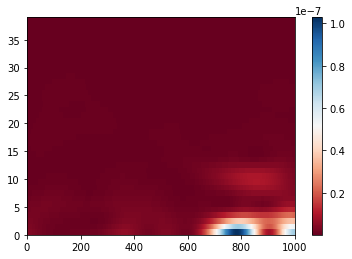

In [78]:
fig, ax = plt.subplots()
c = ax.pcolormesh(np.mean(open_power.next(), axis=0), cmap='RdBu')
fig.colorbar(c, ax=ax)
plt.show()

In [ ]:
plt.save("/DATAHDD/shivam/Thesis/Data/CleanSep/morlet_plots")

In [19]:
roi_chan = pd.read_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/ChannelLocations/roi-grasp-small.csv", header=None)
roi = [f'E{n:1}' for n in roi_chan.to_numpy()[0]]
print(roi)

['E3', 'E4', 'E6', 'E7', 'E9', 'E12', 'E13', 'E14', 'E15', 'E16', 'E18', 'E19', 'E20', 'E21', 'E22', 'E24', 'E25', 'E26', 'E27', 'E28', 'E34', 'E41', 'E42', 'E45', 'E48', 'E49', 'E50', 'E51', 'E52', 'E53', 'E54', 'E56', 'E57', 'E58', 'E59', 'E60']


No baseline correction applied


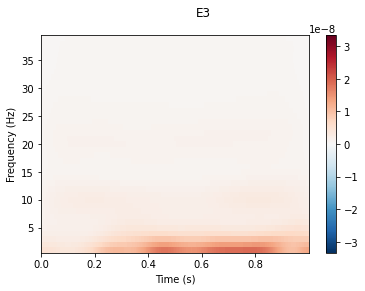

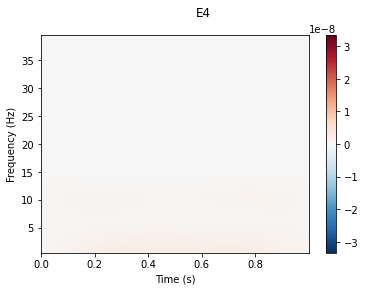

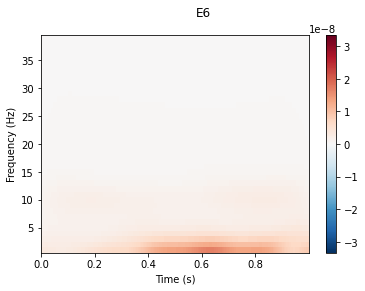

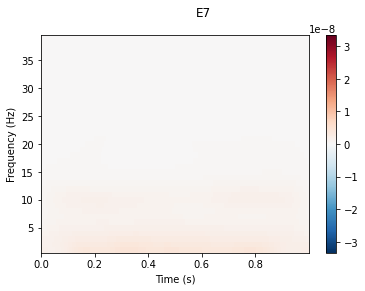

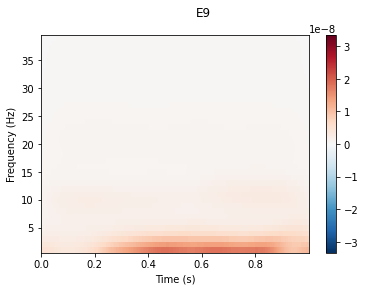

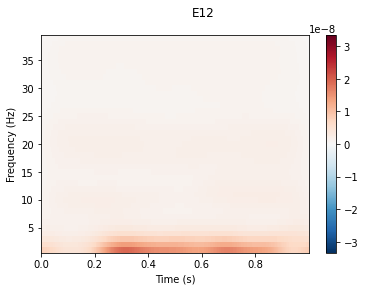

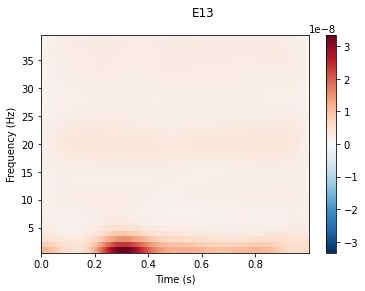

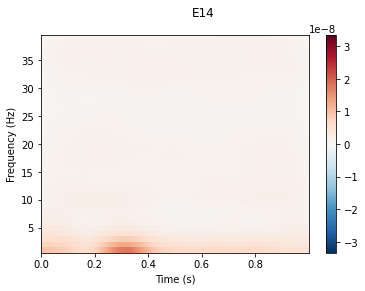

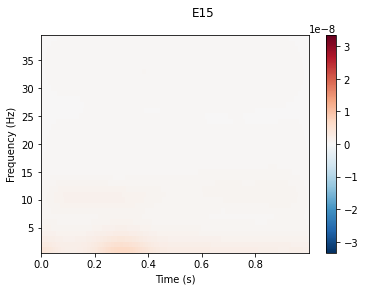

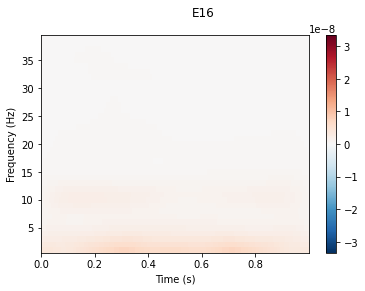

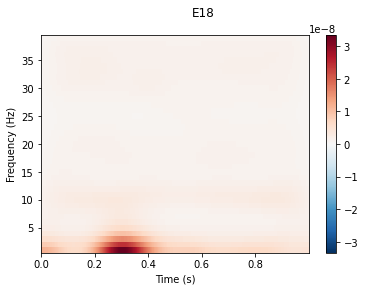

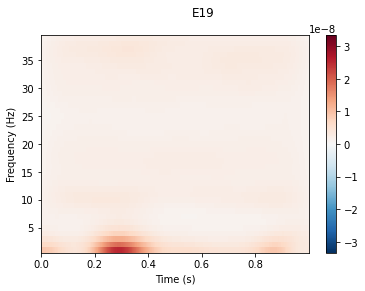

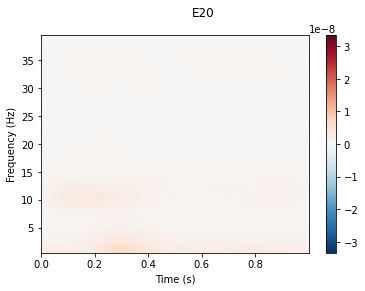

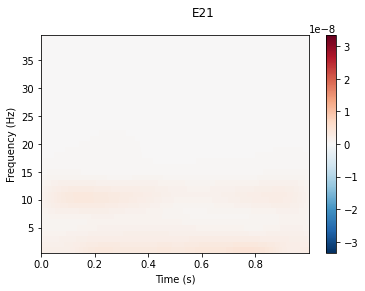

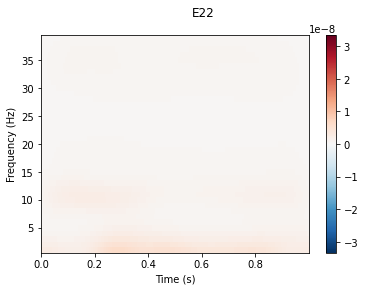

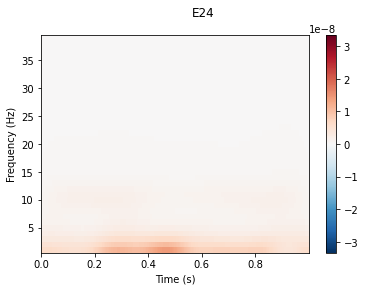

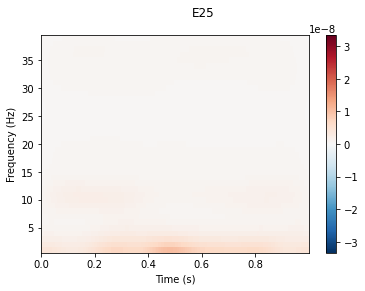

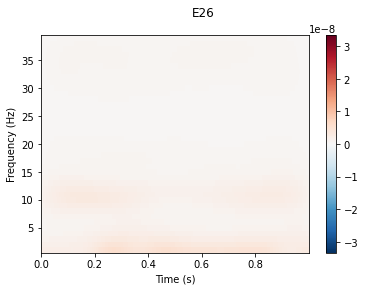

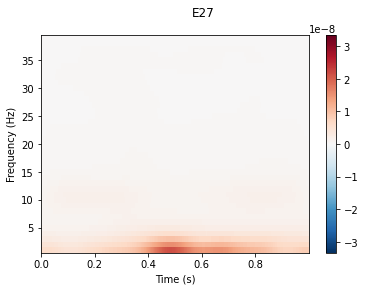

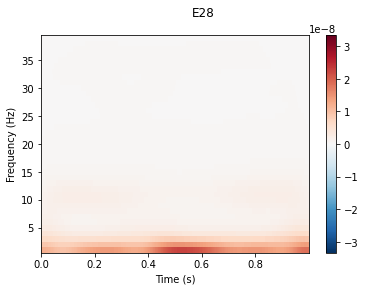

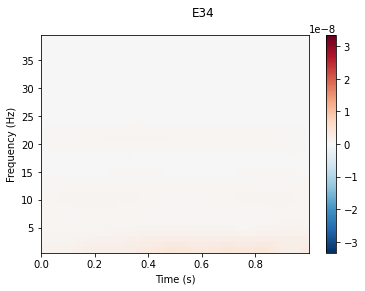

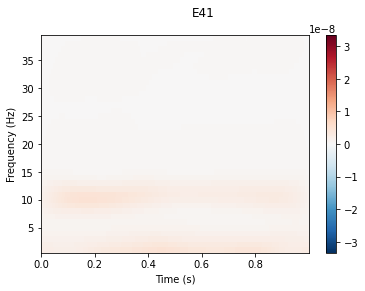

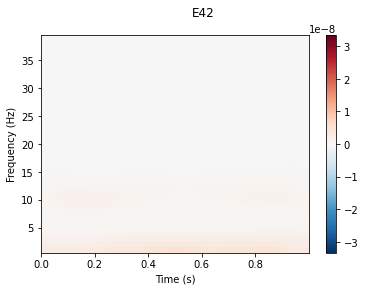

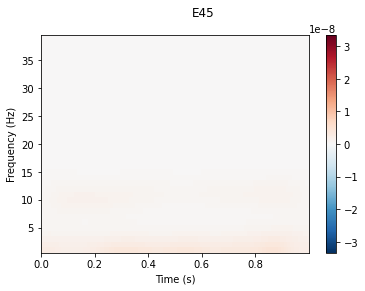

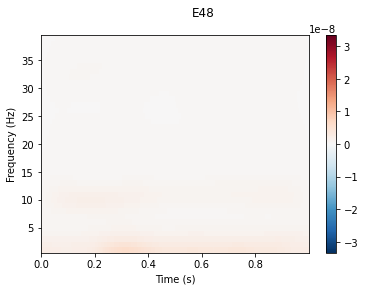

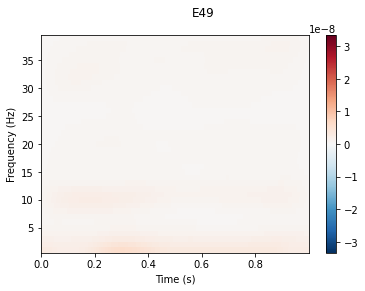

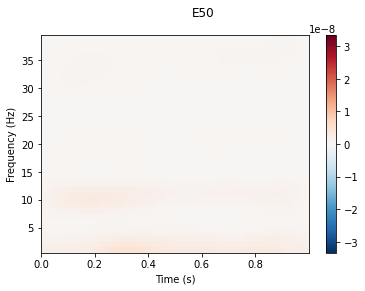

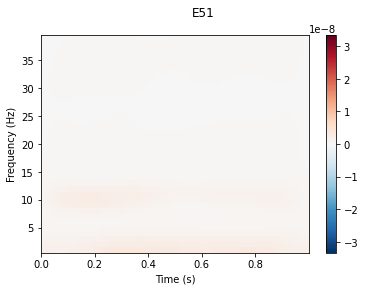

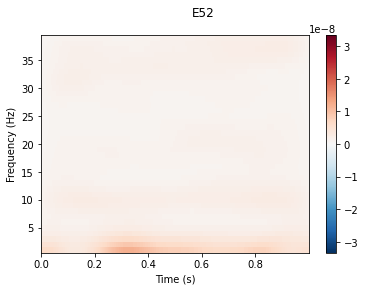

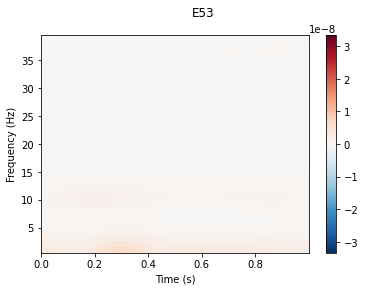

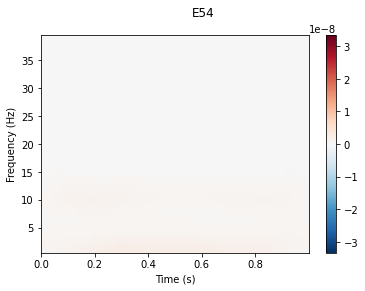

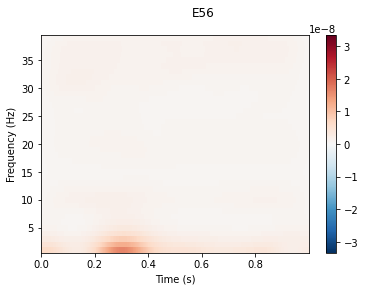

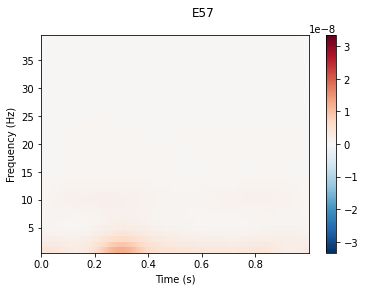

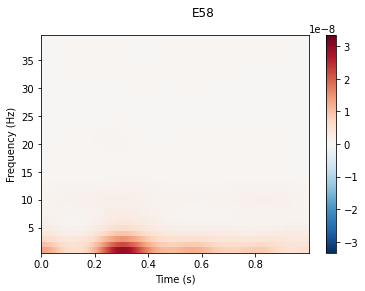

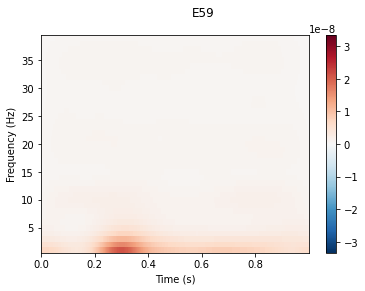

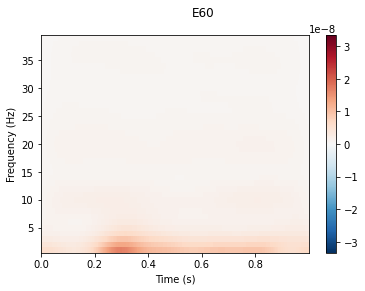

[<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2

In [20]:
open_power.plot(roi, title='auto')

No baseline correction applied


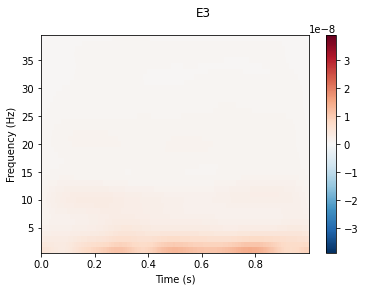

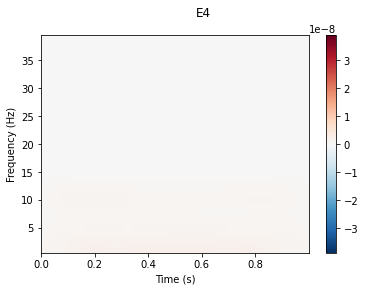

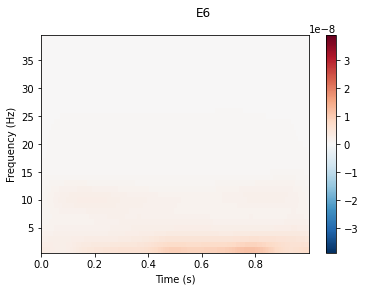

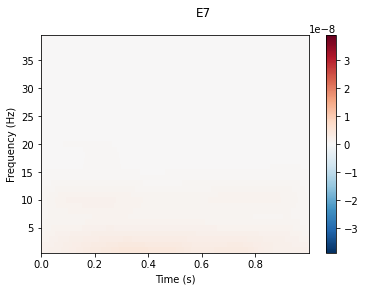

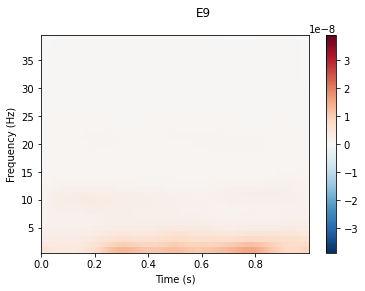

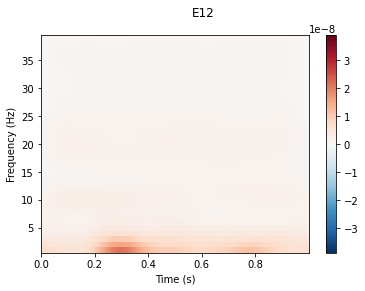

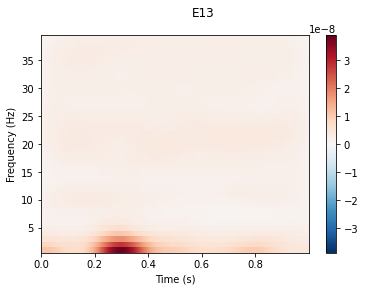

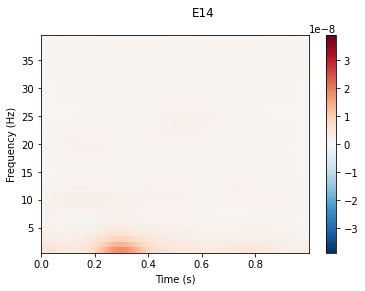

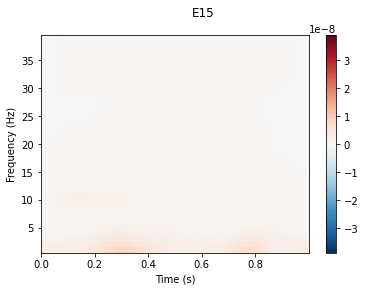

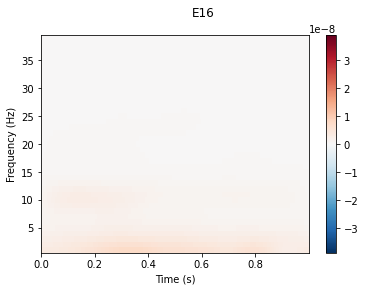

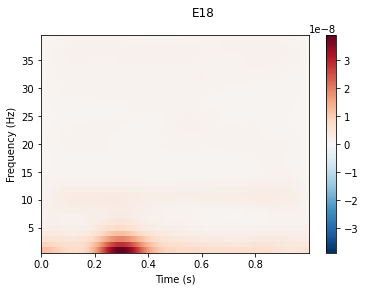

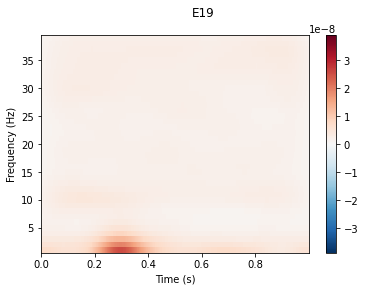

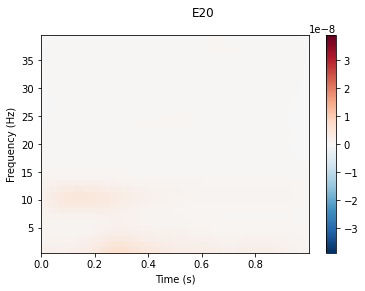

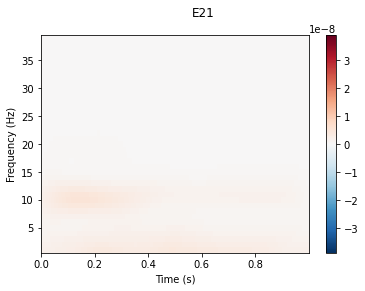

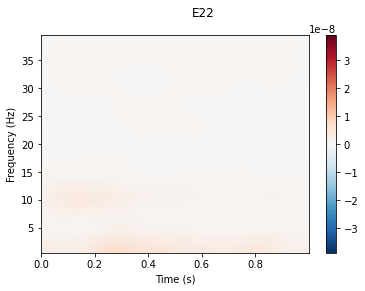

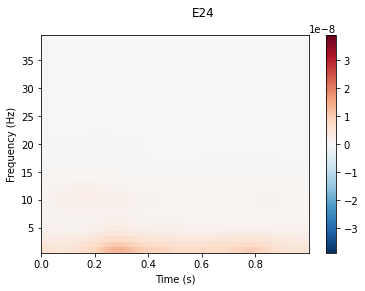

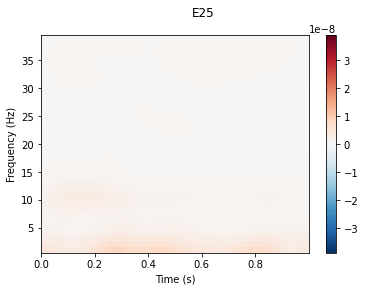

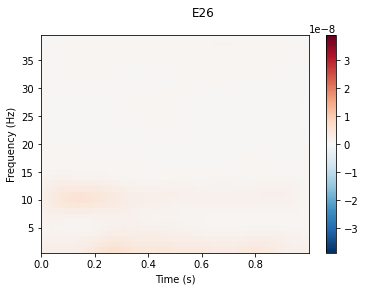

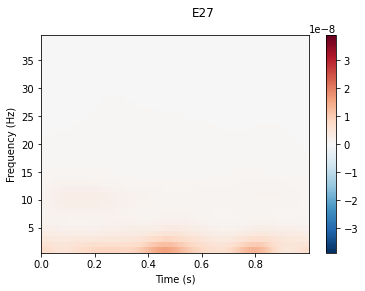

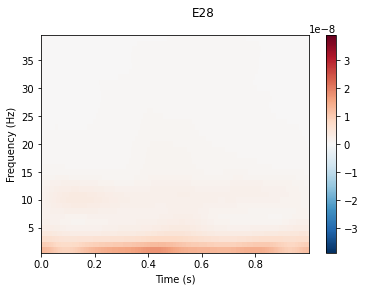

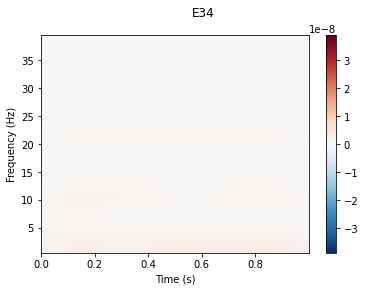

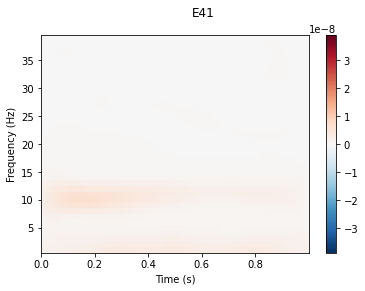

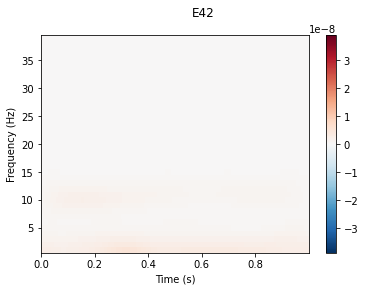

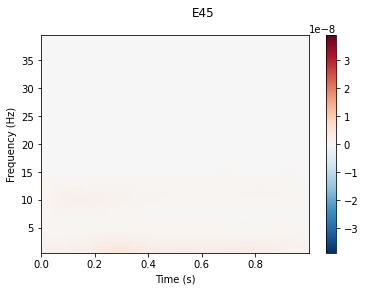

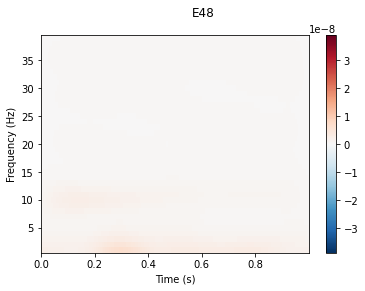

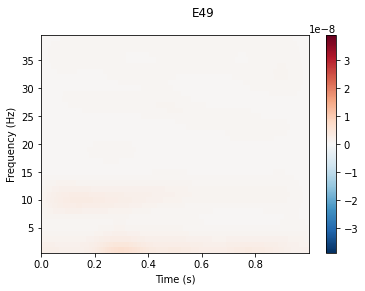

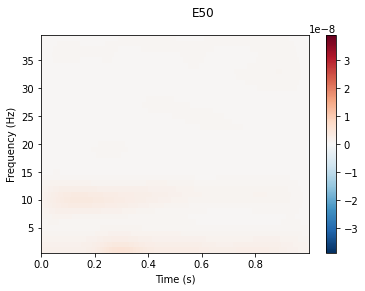

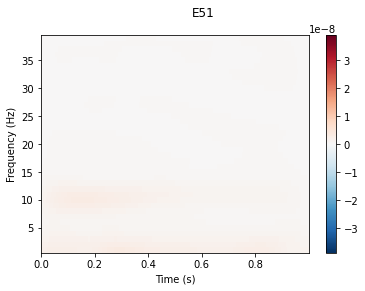

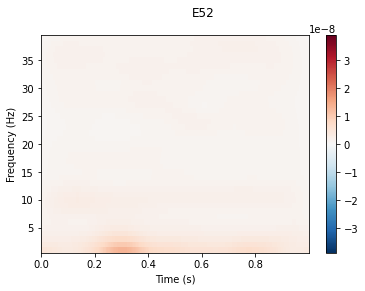

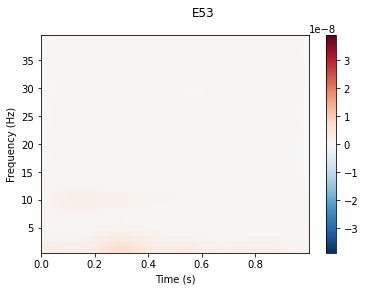

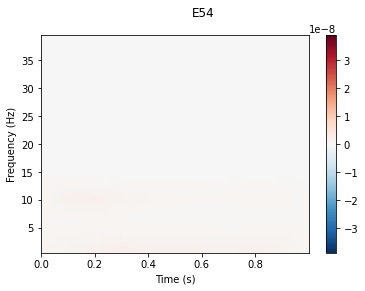

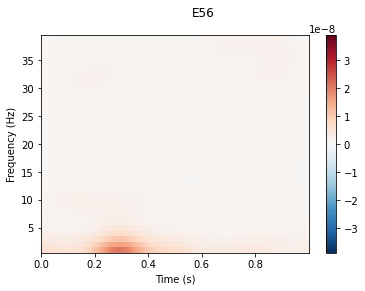

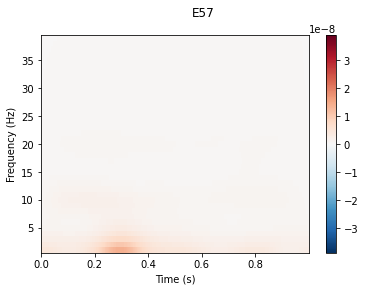

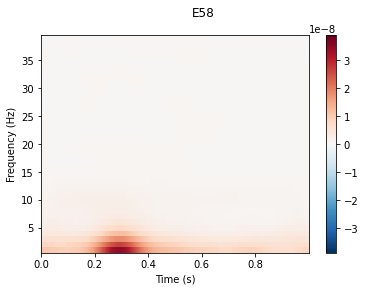

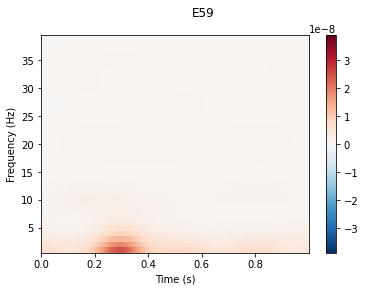

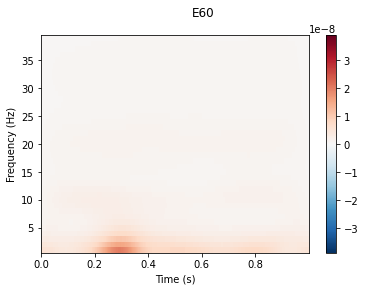

[<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2

In [21]:
close_power.plot(roi, title='auto')

In [ ]:
# Feed wavelet images through classifiers and check channel-wise accuracy